In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.weight_norm as weight_norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import os
import scipy.stats as stats

In [2]:
# 1. Configuration and Hyperparameters
class Config:
    DATA_PATH = '/root/autodl-tmp/Gold.csv' 
    SEQ_LEN = 128      
    BATCH_SIZE = 64
    LATENT_DIM = 10    
    CHANNELS = [32, 32, 32, 32, 32, 32, 32] 
    KERNEL_SIZE = 3     
    DROPOUT = 0.05
    LR = 0.00005         
    N_EPOCHS = 2000   
    N_CRITIC = 5        
    LAMBDA_GP = 10     
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {Config.DEVICE}")

Using device: cuda


In [3]:
# 2. Core TCN module 
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [4]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        # first convolution layer
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.LeakyReLU(0.2) 
        self.dropout1 = nn.Dropout(dropout)

        # second convolution layer
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        # residual connection 
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu2(out + res) # add residual connection

In [ ]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i 
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size,
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [6]:
# 3. Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = TemporalConvNet(num_inputs=Config.LATENT_DIM, 
                                   num_channels=Config.CHANNELS, 
                                   kernel_size=Config.KERNEL_SIZE, 
                                   dropout=Config.DROPOUT)
        self.output_layer = nn.Conv1d(Config.CHANNELS[-1], 1, kernel_size=1)

    def forward(self, x):
        y = self.tcn(x)
        return self.output_layer(y) 

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input dimension: 1 
        self.tcn = TemporalConvNet(num_inputs=1, 
                                   num_channels=Config.CHANNELS, 
                                   kernel_size=Config.KERNEL_SIZE, 
                                   dropout=Config.DROPOUT)
        # fully connected layer 
        self.linear = nn.Linear(Config.CHANNELS[-1], 1)

    def forward(self, x):
        y = self.tcn(x) 
        y_last = y[:, :, -1] 
        return self.linear(y_last)

In [8]:
# 4. Data processing
def get_data():
    if not os.path.exists(Config.DATA_PATH):
        raise FileNotFoundError(f"Data file not found: {Config.DATA_PATH}")
    
    df = pd.read_csv(Config.DATA_PATH)
    
    df['ClPr'] = pd.to_numeric(df['ClPr'], errors='coerce')
    
    df = df.dropna(subset=['ClPr'])
    
    df['Date'] = pd.to_datetime(df['TrdDt'])
    df = df.sort_values('Date')
    prices = df['ClPr'].astype(float).values
    returns = np.diff(np.log(prices + 1e-8))
    returns = returns[~np.isnan(returns)]
    returns = returns[~np.isinf(returns)]

    scaler = StandardScaler()
    returns_std = scaler.fit_transform(returns.reshape(-1, 1)).flatten()

    X = []
    for i in range(len(returns_std) - Config.SEQ_LEN):
        X.append(returns_std[i : i + Config.SEQ_LEN])

    X = np.array(X)
    
    X = X[:, np.newaxis, :] 

    return torch.FloatTensor(X), scaler

dataset, scaler = get_data()
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
print(f"Gold AU9999 data loaded. Dataset shape: {dataset.shape}")

Gold AU9999 data loaded. Dataset shape: torch.Size([2290, 1, 128])


In [9]:
# 5. Gradient penalty and training utilities
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Compute gradient penalty term for WGAN-GP"""
    alpha = torch.rand(real_samples.size(0), 1, 1).to(Config.DEVICE)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(Config.DEVICE)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    gradient_penalty = ((gradients_norm - 1) ** 2).mean() * Config.LAMBDA_GP
    
    return gradient_penalty

In [ ]:
# 6. Main training loop
generator = Generator().to(Config.DEVICE)
discriminator = Discriminator().to(Config.DEVICE)

optimizer_G = optim.Adam(generator.parameters(), lr=Config.LR, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=Config.LR, betas=(0.5, 0.9))

print("Start QuantGAN (TCN-WGAN-GP) training...")
g_losses, d_losses = [], []

for epoch in range(Config.N_EPOCHS):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(Config.DEVICE)
        
        optimizer_D.zero_grad()
        
        z = torch.randn(Config.BATCH_SIZE, Config.LATENT_DIM, Config.SEQ_LEN).to(Config.DEVICE)
        fake_imgs = generator(z)
        
        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs)
        
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
        d_loss.backward()
        optimizer_D.step()
        
        if i % Config.N_CRITIC == 0:
            optimizer_G.zero_grad()
            fake_imgs = generator(z) 
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{Config.N_EPOCHS}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

/root/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Start QuantGAN (TCN-WGAN-GP) training...


/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 0/2000] [D loss: 7.8561] [G loss: 0.4465]
[Epoch 100/2000] [D loss: -3.4433] [G loss: 5.5728]
[Epoch 200/2000] [D loss: -2.6680] [G loss: 10.4590]
[Epoch 300/2000] [D loss: -1.5190] [G loss: 18.1167]
[Epoch 400/2000] [D loss: -1.4790] [G loss: 26.6355]
[Epoch 500/2000] [D loss: -1.1427] [G loss: 28.6697]
[Epoch 600/2000] [D loss: -1.0703] [G loss: 23.1358]
[Epoch 700/2000] [D loss: -0.8578] [G loss: 25.9469]
[Epoch 800/2000] [D loss: -0.5853] [G loss: 27.9686]
[Epoch 900/2000] [D loss: -0.7974] [G loss: 25.4180]
[Epoch 1000/2000] [D loss: -1.3179] [G loss: 21.7467]
[Epoch 1100/2000] [D loss: -1.4695] [G loss: 21.6598]
[Epoch 1200/2000] [D loss: -0.9297] [G loss: 20.0382]
[Epoch 1300/2000] [D loss: -0.9149] [G loss: 19.1548]
[Epoch 1400/2000] [D loss: -0.9689] [G loss: 17.2022]
[Epoch 1500/2000] [D loss: -1.5068] [G loss: 17.8979]
[Epoch 1600/2000] [D loss: -1.2188] [G loss: 16.9747]
[Epoch 1700/2000] [D loss: -1.5244] [G loss: 16.1519]
[Epoch 1800/2000] [D loss: -1.9144] [G loss

In [11]:
# 7. Evaluation and visualization 
generator.eval()
with torch.no_grad():
    z = torch.randn(2000, Config.LATENT_DIM, Config.SEQ_LEN).to(Config.DEVICE)
    generated_data = generator(z).cpu().numpy().squeeze()
    
    generated_returns = scaler.inverse_transform(generated_data.reshape(-1, 1)).flatten()
    real_returns = scaler.inverse_transform(dataset.numpy().reshape(-1, 1)).flatten()

plt.style.use('seaborn-v0_8')

In [57]:
S0 = 100

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -10, 10) 
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

real_data_tensor = dataset.cpu().numpy()
real_returns_flat = scaler.inverse_transform(real_data_tensor[:, 0, :].reshape(-1, 1)).flatten()
real_len = min(len(real_returns_flat), 5000)
real_returns_arr = real_returns_flat[:real_len]
real_price_arr = returns_to_index(real_returns_arr, S0)

n_simulations = 100
simulated_price_paths = []
simulated_returns_paths = []

netG = generator
device = Config.DEVICE
latent_dim = Config.LATENT_DIM
seq_len = Config.SEQ_LEN 
gen_seq_len = 5000 

if netG:
    netG.eval()
    target_mean = 0.0 
    
    with torch.no_grad():
        for _ in range(n_simulations):
            z = torch.randn(1, latent_dim, gen_seq_len).to(device)
            fake_data = netG(z).cpu().numpy().squeeze()
            fake_ret = scaler.inverse_transform(fake_data.reshape(-1, 1)).flatten()
            
            current_mean = np.mean(fake_ret)
            fake_ret = fake_ret - current_mean + target_mean
            
            simulated_returns_paths.append(fake_ret)
            simulated_price_paths.append(returns_to_index(fake_ret, S0))

    percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
    fan_data = np.percentile(simulated_price_paths, percentiles, axis=0)
    median_path = fan_data[5]
else:
    median_path = np.zeros(2000)
    fan_data = np.zeros((11, 2000))
    simulated_returns_paths = [np.random.randn(2000)*0.01]

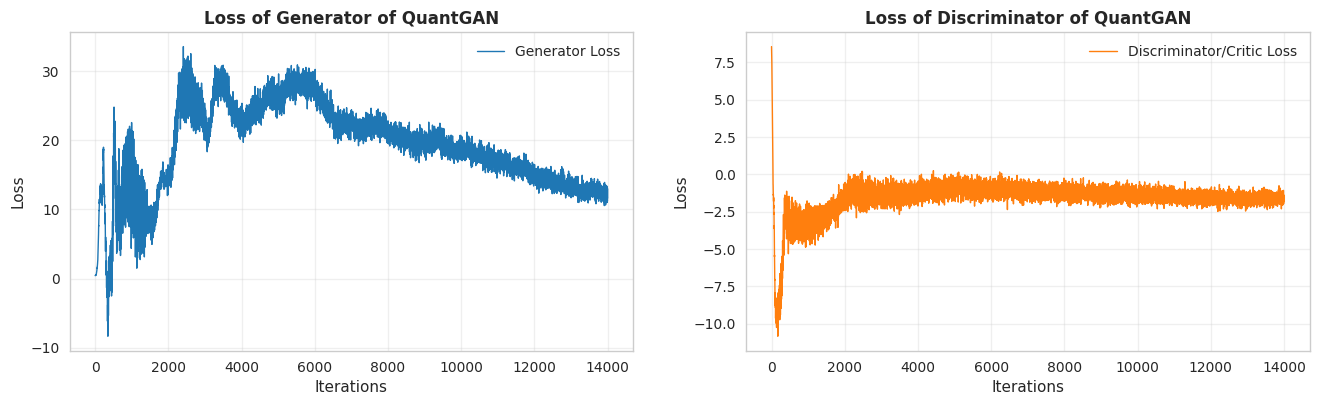

In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 

# Training Loss
D_losses = d_losses
G_losses = g_losses

ax1 = plt.subplot(5, 2, 1)
plt.plot(G_losses, label='Generator Loss', color='#1f77b4', linewidth=1)
plt.title("Loss of Generator of QuantGAN", fontsize=12, fontweight='bold')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(5, 2, 2)
plt.plot(D_losses, label='Discriminator/Critic Loss', color='#ff7f0e', linewidth=1)
plt.title("Loss of Discriminator of QuantGAN", fontsize=12, fontweight='bold')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

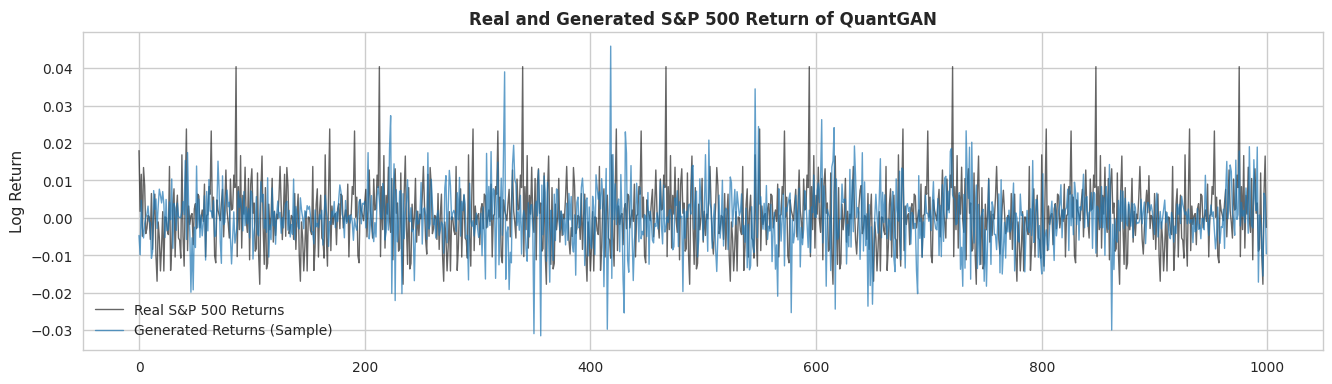

In [49]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 

# Real and Generated Return Comparison
ax3 = plt.subplot(5, 1, 2)
zoom_len =1000
plt.plot(real_returns_arr[:zoom_len], label='Real S&P 500 Returns', color='black', alpha=0.6, linewidth=1)
plt.plot(simulated_returns_paths[0][:zoom_len], label='Generated Returns (Sample)', color='#1f77b4', alpha=0.7, linewidth=1)
plt.title("Real and Generated S&P 500 Return of QuantGAN", fontsize=12, fontweight='bold')
plt.ylabel("Log Return")
plt.legend()

Text(0, 0.5, 'Log Return')

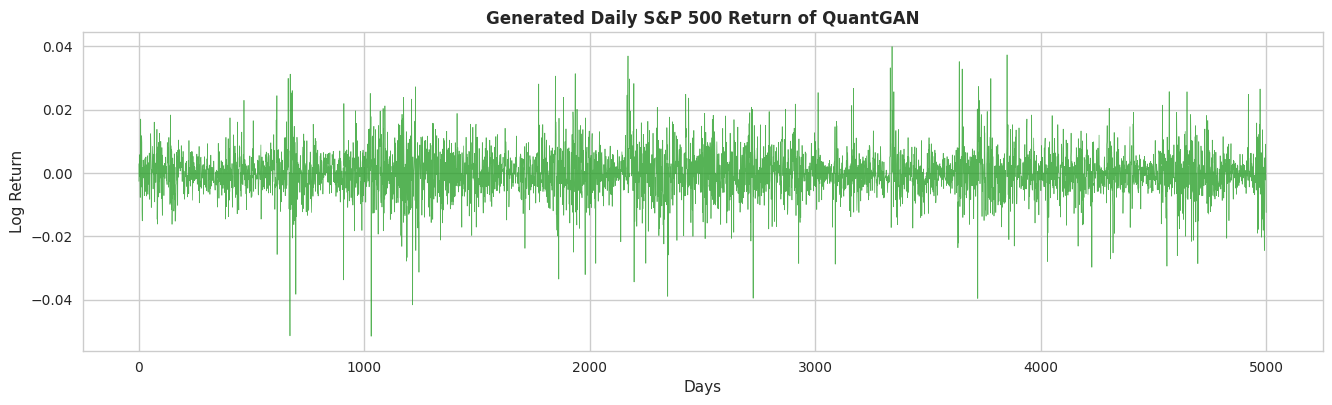

In [59]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 
# Generated Daily Return
ax4 = plt.subplot(5, 1, 3)
plt.plot(simulated_returns_paths[0], color='#2ca02c', alpha=0.8, linewidth=0.5)
plt.title("Generated Daily S&P 500 Return of QuantGAN", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Log Return")

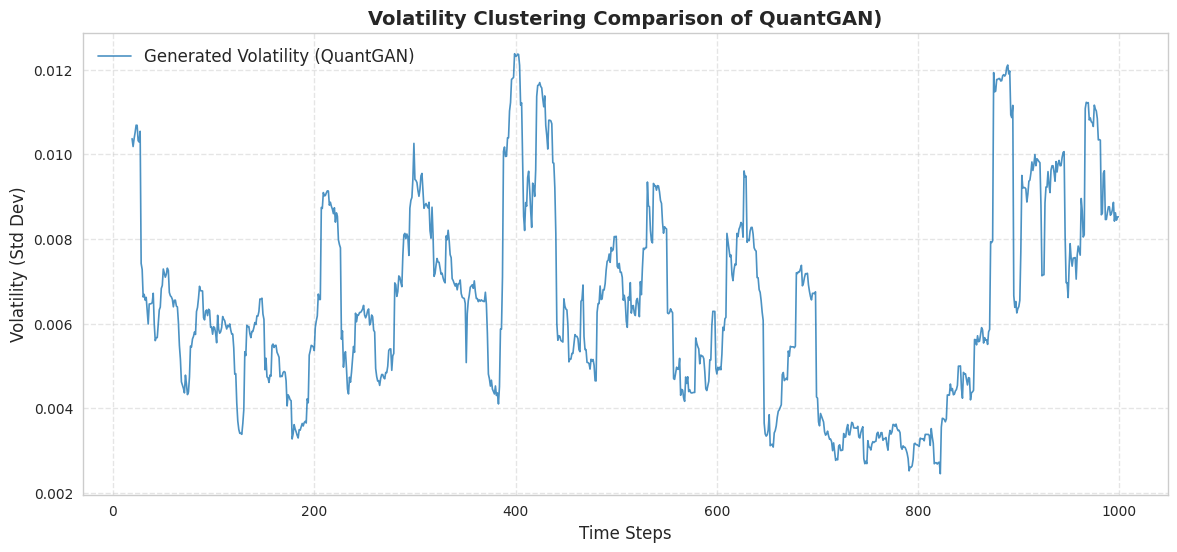

In [54]:
WINDOW_SIZE = 20
volatility_fake = pd.Series(generated_returns).rolling(window=WINDOW_SIZE).std()

plt.figure(figsize=(14, 6))
plt.plot(volatility_fake[:1000], label='Generated Volatility (QuantGAN)', color='#1f77b4', alpha=0.8, linewidth=1.2)
plt.title(f'Volatility Clustering Comparison of QuantGAN)', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Volatility (Std Dev)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

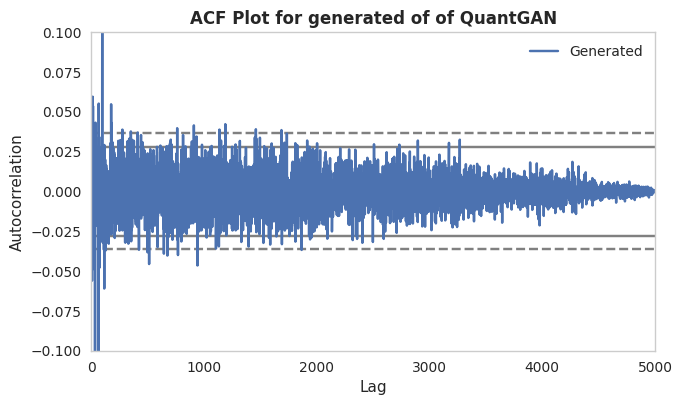

In [18]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 
ax6 = plt.subplot(5, 2, 9)
# s_real = pd.Series(real_returns_arr)
s_fake = pd.Series(simulated_returns_paths[0])

# pd.plotting.autocorrelation_plot(s_real, label='Real', color='black', ax=ax6)
pd.plotting.autocorrelation_plot(s_fake, label='Generated', ax=ax6)

ax6.set_title("ACF Plot for generated of of QuantGAN", fontsize=12, fontweight='bold')
ax6.set_xlim([0, 5000])
ax6.set_ylim([-0.1, 0.1]) 
ax6.legend()

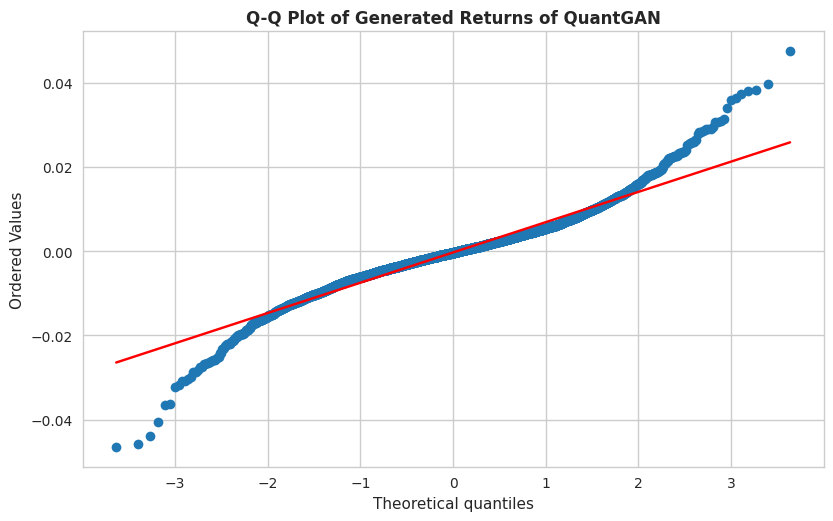

In [19]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 
# Q-Q Plot
ax7 = plt.subplot(5, 2, 10)
stats.probplot(simulated_returns_paths[0], dist="norm", plot=ax7)
ax7.get_lines()[0].set_markerfacecolor('#1f77b4') 
ax7.get_lines()[1].set_color('red') 
ax7.set_title("Q-Q Plot of Generated Returns of QuantGAN", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

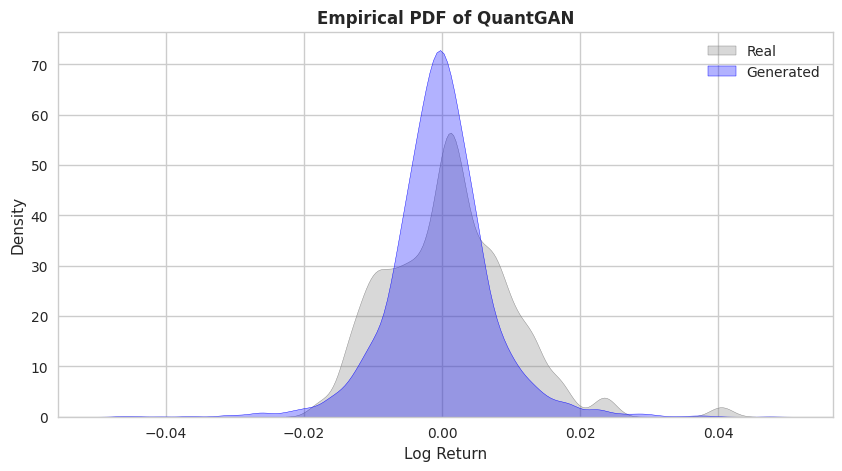

In [20]:
# KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(real_returns_arr, label='Real', fill=True, color='grey', alpha=0.3)
sns.kdeplot(simulated_returns_paths[0], label='Generated', fill=True, color='blue', alpha=0.3)
plt.title("Empirical PDF of QuantGAN", fontsize=12, fontweight='bold')
plt.xlabel("Log Return")
plt.legend()
plt.show()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
real_stats = pd.Series(real_returns_arr, name="Real").describe()
quantgan_returns = np.array(simulated_returns_paths).flatten()
quantgan_stats = pd.Series(quantgan_returns, name="QuantGAN").describe()
comparison_table_quantgan = pd.concat([real_stats, quantgan_stats], axis=1)
display(comparison_table_quantgan)

,Real,QuantGAN
count,5000.000000,500000.000000
mean,0.001020,-0.000000
std,0.009017,0.007388
min,-0.017716,-0.094194
25%,-0.005360,-0.003637
50%,0.000846,-0.000013
75%,0.006359,0.003656
max,0.040402,0.066898


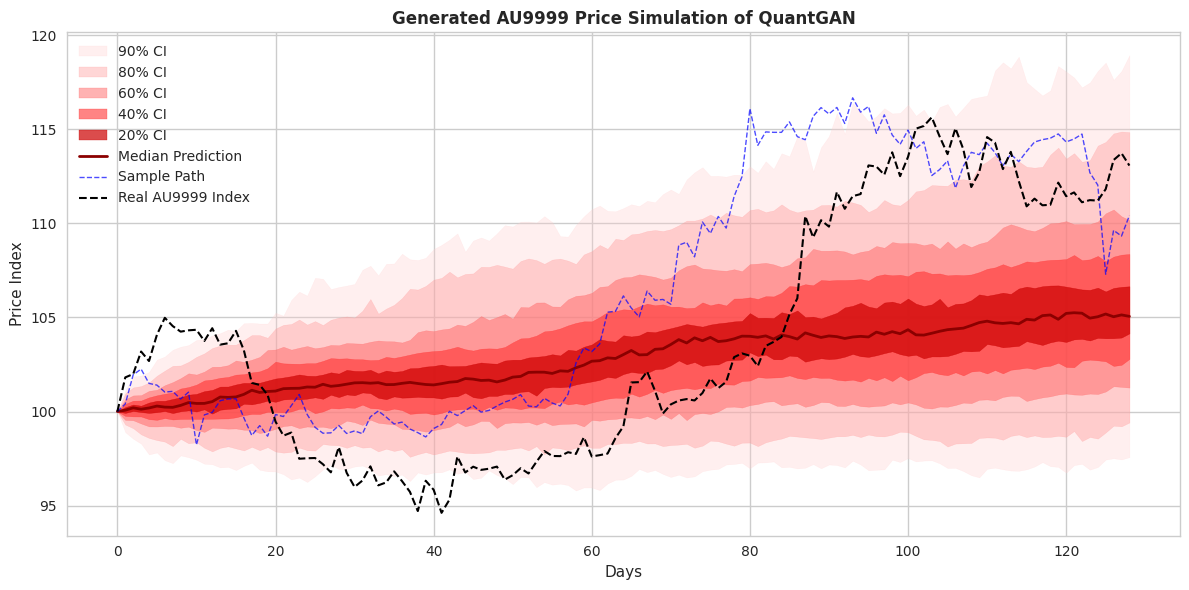

In [ ]:
def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns) 
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

def get_real_price_path_from_gold_csv(max_len=None, start_price=None):
    df_real = pd.read_csv(Config.DATA_PATH)

    if {'TrdDt', 'ClPr'}.issubset(df_real.columns):
        df_real['Date'] = pd.to_datetime(df_real['TrdDt'])
        df_real = df_real.sort_values('Date')
        prices = df_real['ClPr'].astype(float).values
    else:
        if 'Close' in df_real.columns:
            prices = df_real['Close'].values
        else:
            prices = df_real.iloc[:, 1].values

    real_returns = np.diff(np.log(prices + 1e-8))

    if max_len is not None:
        real_returns = real_returns[:max_len]

    if start_price is None:
        start_price = float(prices[0])

    real_price_index = returns_to_index(real_returns, start_price)
    return real_price_index

def generate_simulated_price_paths(
    netG,
    scaler,
    n_simulations=300,
    gen_seq_len=None,
    S0=100.0
):
    if gen_seq_len is None:
        gen_seq_len = Config.SEQ_LEN

    netG.eval()
    simulated_price_paths = []

    with torch.no_grad():
        for _ in range(n_simulations):
            z = torch.randn(1, Config.LATENT_DIM, gen_seq_len).to(Config.DEVICE)
            fake = netG(z).cpu().numpy().squeeze()  

            fake_returns = scaler.inverse_transform(fake.reshape(-1, 1)).flatten()

            price_path = returns_to_index(fake_returns, S0)
            simulated_price_paths.append(price_path)

    simulated_price_paths = np.array(simulated_price_paths)
    return simulated_price_paths

def build_fan_chart_data(simulated_price_paths, percentiles=None):
    if percentiles is None:
        percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

    fan_data = np.percentile(simulated_price_paths, percentiles, axis=0)
    return fan_data, percentiles

def plot_fan_chart(
    simulated_price_paths,
    fan_data,
    percentiles,
    real_price_path=None,
    title="Generated AU9999 Price Simulation of QuantGAN"
):
   
    plt.style.use('seaborn-v0_8-whitegrid')

    T = simulated_price_paths.shape[1]
    x_axis = range(T) # time axis

    fig = plt.figure(figsize=(12, 6))
    plt.fill_between(x_axis, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
    plt.fill_between(x_axis, fan_data[1], fan_data[9],  color='#ff9999', alpha=0.4, label='80% CI')
    plt.fill_between(x_axis, fan_data[2], fan_data[8],  color='#ff6666', alpha=0.5, label='60% CI')
    plt.fill_between(x_axis, fan_data[3], fan_data[7],  color='#ff3333', alpha=0.6, label='40% CI')
    plt.fill_between(x_axis, fan_data[4], fan_data[6],  color='#cc0000', alpha=0.7, label='20% CI')

    plt.plot(x_axis, fan_data[5], color='darkred', linewidth=2, label='Median Prediction')

    sample_path = simulated_price_paths[0]
    plt.plot(x_axis, sample_path, color='blue', linewidth=1, linestyle='--', alpha=0.7, label='Sample Path')

    if real_price_path is not None:
        real_price_len = min(len(real_price_path), len(x_axis))
        plt.plot(x_axis[:real_price_len], real_price_path[:real_price_len], 
                 color='black', linewidth=1.5, linestyle='--', label='Real AU9999 Index')

    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel("Days")
    plt.ylabel("Price Index")
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

GEN_SEQ_LEN = Config.SEQ_LEN  
N_SIM = 300
S0 = 100.0

sim_paths = generate_simulated_price_paths(
    netG=netG,
    scaler=scaler,
    n_simulations=N_SIM,
    gen_seq_len=GEN_SEQ_LEN,
    S0=S0
)

fan_data, pct_list = build_fan_chart_data(sim_paths)

real_path = get_real_price_path_from_gold_csv(
    max_len=GEN_SEQ_LEN,
    start_price=S0
)

plot_fan_chart(
    simulated_price_paths=sim_paths,
    fan_data=fan_data,
    percentiles=pct_list,
    real_price_path=real_path,
    title="Generated AU9999 Price Simulation of QuantGAN"
)